In [103]:
from dsa2000_common.common.enu_frame import ENU
from dsa2000_cal.assets.registries import array_registry
from dsa2000_cal.assets.content_registry import fill_registries
import astropy.time as at
import astropy.units as au
import astropy.coordinates as ac
import pylab as plt

fill_registries()
array = array_registry.get_instance(array_registry.get_match('dsa2000W'))

antennas = array.get_antennas()
array_location = array.get_array_location()
obstime = at.Time('2022-01-01T00:00:00', scale='utc')
antennas_enu = antennas.get_itrs(obstime=obstime, location=array_location).transform_to(
    ENU(0, 0, 1, obstime=obstime, location=array_location)
)
antennas_enu_xyz = antennas_enu.cartesian.xyz.T



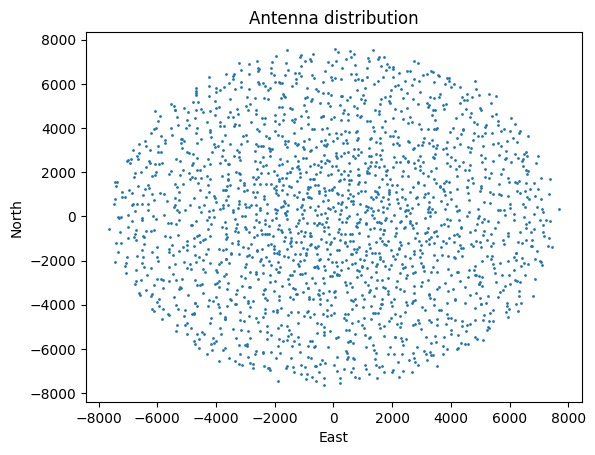

In [104]:
plt.scatter(antennas_enu_xyz[:,0], antennas_enu_xyz[:,1],s=1)
plt.xlabel('East')
plt.ylabel('North')
plt.title('Antenna distribution')
plt.show()

In [111]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import t

def truncated_student_t_pdf(x, df, sigma, T):
    """
    Compute the PDF of a truncated Student's t-distribution with scale parameter sigma.

    Args:
        x (float or np.ndarray): Points at which to evaluate the PDF.
        df (float): Degrees of freedom.
        sigma (float): Scale parameter (standard deviation).
        T (float): Truncation threshold.

    Returns:
        np.ndarray: The probability density values.
    """
    normalization = t.cdf(T / sigma, df) - t.cdf(0. / sigma, df)  # Normalization over [-T, T]
    pdf_values = t.pdf(x / sigma, df) / (sigma * normalization)
    pdf_values[np.abs(x) > T] = 0  # Set PDF to 0 outside [-T, T]
    return pdf_values

def neg_log_likelihood(params, data, df, T):
    """
    Negative log-likelihood for the truncated Student's t-distribution.

    Args:
        params (list): [sigma], scale parameter.
        data (np.ndarray): The data points (2D coordinates).
        df (float): Degrees of freedom (fixed).
        T (float): Truncation threshold.

    Returns:
        float: Negative log-likelihood value.
    """
    sigma = params[0]
    if sigma <= 0:
        return np.inf  # Sigma must be positive

    # Compute independent PDFs for x and y components
    x, y = data[:, 0], data[:, 1]
    uv = np.sqrt(x**2 + y**2)
    pdf_uv = truncated_student_t_pdf(uv, df, sigma, T)
    # pdf_x = truncated_student_t_pdf(x, df, sigma, T)
    # pdf_y = truncated_student_t_pdf(y, df, sigma, T)

    # Combine PDFs (independent components)
    # pdf_joint = pdf_x * pdf_y
    pdf_joint = pdf_uv
    # Negative log-likelihood
    nll = -np.sum(np.log(pdf_joint + 1e-9))  # Add small value to avoid log(0)
    return nll

def fit_truncated_student_t_sigma(data, df, T):
    """
    Fit the scale parameter (sigma) for a truncated Student's t-distribution with fixed degrees of freedom.

    Args:
        data (np.ndarray): The 2D data points (N x 2 array).
        df (float): Degrees of freedom (fixed).
        T (float): Truncation threshold.

    Returns:
        dict: Fitted parameters {"sigma": fitted scale parameter}.
    """
    # Initial guess for sigma
    initial_guess = [T/2]
    print(f"Initial guess: sigma={initial_guess[0]:.2f}")

    # Optimize the negative log-likelihood
    result = minimize(
        neg_log_likelihood,
        x0=initial_guess,
        args=(data, df, T),
        bounds=[(T/100, None)],  # sigma > 0
        method="L-BFGS-B",
    )

    if result.success:
        return {"sigma": result.x[0]}
    else:
        raise RuntimeError("Optimization failed: " + result.message)

def line_search_df(data, df_values, T):
    """
    Perform a line search over fixed degrees of freedom (df) to find the best-fitting df.

    Args:
        data (np.ndarray): The 2D data points (N x 2 array).
        df_values (list): List of df values to test.
        T (float): Truncation threshold.

    Returns:
        dict: Best df and corresponding sigma with lowest negative log-likelihood.
    """
    best_nll = np.inf
    best_params = None

    for df in df_values:
        try:
            # Fit sigma for the current df
            params = fit_truncated_student_t_sigma(data, df, T)
            sigma = params["sigma"]

            # Compute negative log-likelihood for this df and sigma
            nll = neg_log_likelihood([sigma], data, df, T)

            if nll < best_nll:
                best_nll = nll
                best_params = {"df": df, "sigma": sigma, "nll": nll}
                print(f"New best fit: df={df}, sigma={sigma:.2f}, NLL={nll:.2f}")
        except RuntimeError as e:
            print(f"Failed to fit for df={df}: {e}")

    if best_params is None:
        raise RuntimeError("No valid df value found during line search.")

    return best_params

In [112]:
T = np.linalg.norm(antennas_enu_xyz, axis=-1).max() #+ 50 * au.m  # Truncation threshold
print(f"Truncation threshold: {T:.2f}")

Truncation threshold: 7806.27 m


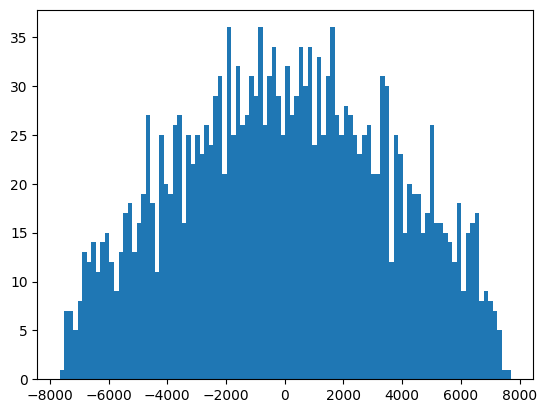

In [116]:

plt.hist(antennas_enu_xyz[:,0],bins=100)
plt.show()

In [113]:
# Fit the truncated Student's t-distribution
fitted_params = line_search_df(antennas_enu_xyz.to('km').value, [1,2,3,4,5,6,7], T.to('km').value)
print("Fitted parameters:", fitted_params)

Initial guess: sigma=3.90
New best fit: df=1, sigma=300.28, NLL=4208.62
Initial guess: sigma=3.90
Initial guess: sigma=3.90
New best fit: df=3, sigma=303.32, NLL=4208.57
Initial guess: sigma=3.90
Failed to fit for df=4: Optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH
Initial guess: sigma=3.90
Initial guess: sigma=3.90
Failed to fit for df=6: Optimization failed: ABNORMAL_TERMINATION_IN_LNSRCH
Initial guess: sigma=3.90
New best fit: df=7, sigma=921.02, NLL=4208.50
Fitted parameters: {'df': 7, 'sigma': 921.018723463256, 'nll': 4208.497601641093}


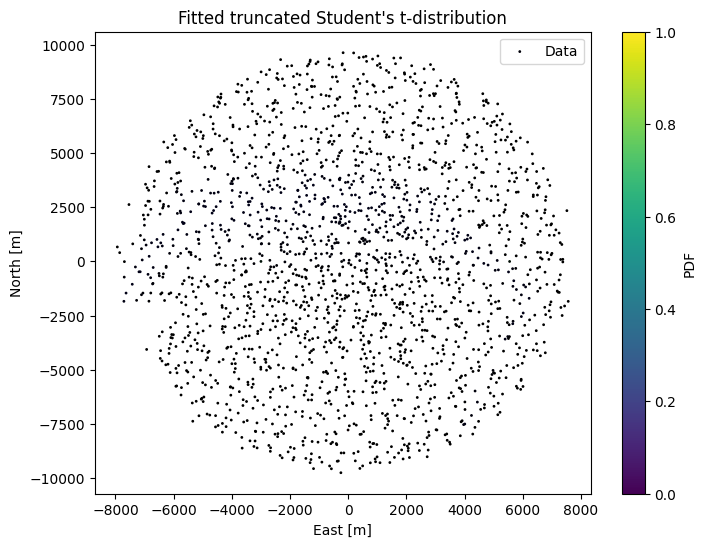

In [80]:
# Plot the data and the fitted distribution
df = fitted_params["df"]
sigma = fitted_params["sigma"]
pdf_values = truncated_student_t_pdf(antennas_enu_xyz, df, sigma, T)

plt.figure(figsize=(8, 6))
sc = plt.scatter(antennas_enu_xyz[:, 0], antennas_enu_xyz[:, 1], c=pdf_values, s=1, label="Data")
plt.xlabel("East [m]")
plt.ylabel("North [m]")
plt.title("Fitted truncated Student's t-distribution")
plt.colorbar(sc, label="PDF")
plt.legend()
plt.show()

/tmp/ipykernel_12086/1461941614.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  samples[i, 0] = x
/tmp/ipykernel_12086/1461941614.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  samples[i, 1] = y


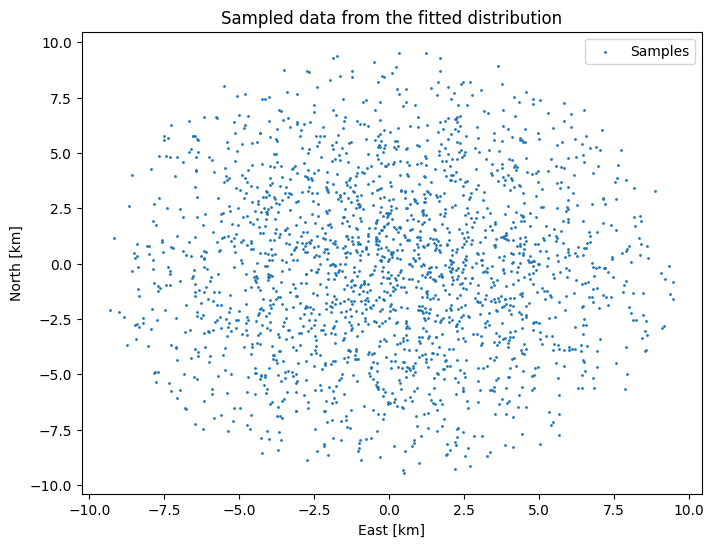

In [81]:
# Sample from the fitted distribution
n_samples = 2048
samples = np.zeros((n_samples, 2))

for i in range(n_samples):
    # Sample x and y independently
    x = t.rvs(df, scale=fitted_params["sigma"], size=1)
    y = t.rvs(df, scale=fitted_params["sigma"], size=1)
    # Truncate samples outside [-T, T]
    while np.sqrt(x**2 + y**2) > T.to('km').value:
        x = t.rvs(df, scale=fitted_params["sigma"], size=1)
        y = t.rvs(df, scale=fitted_params["sigma"], size=1)

    samples[i, 0] = x
    samples[i, 1] = y

# Plot the samples
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1, label="Samples")
plt.xlabel("East [km]")
plt.ylabel("North [km]")
plt.title("Sampled data from the fitted distribution")
plt.legend()
plt.show()

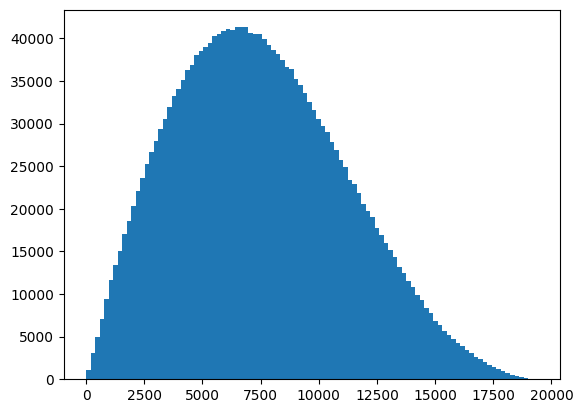

In [97]:
antenna1, antenna2 = np.triu_indices(n_samples, k=1)
uv = np.linalg.norm(antennas_enu_xyz[antenna1] - antennas_enu_xyz[antenna2], axis=-1)
plt.hist(uv, bins=100)
plt.show()

In [98]:
antenna1

array([   0,    0,    0, ..., 2045, 2045, 2046])

In [99]:
antenna2

array([   1,    2,    3, ..., 2046, 2047, 2047])

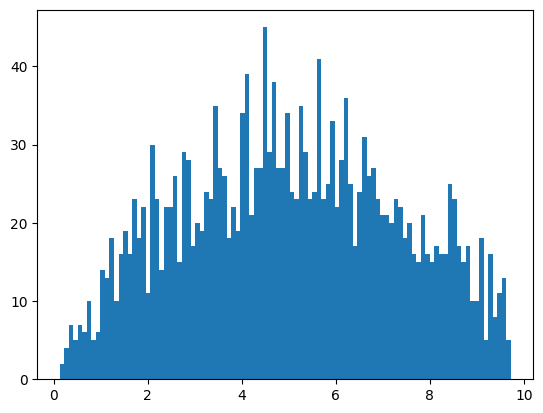

In [101]:
uv = np.linalg.norm(samples, axis=-1)
plt.hist(uv, bins=100)
plt.show()

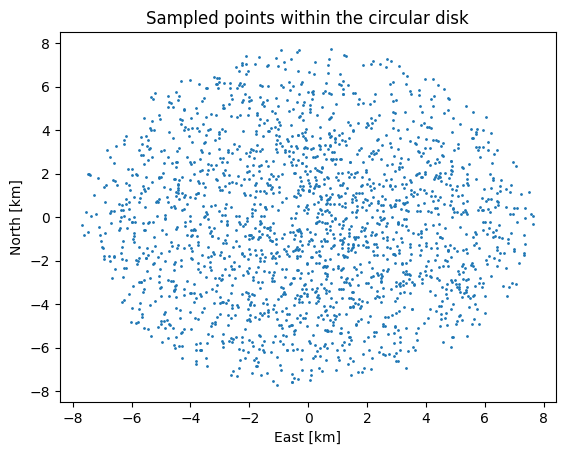

In [136]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA

def sample_kde_in_disk(data, radius, N):
    """
    Sample N points from a KDE density within a circular disk of a given radius.

    Args:
        data (np.ndarray): Input data points (2D array of shape [n_samples, 2]).
        radius (float): Radius of the circular disk.
        N (int): Number of points to sample.

    Returns:
        np.ndarray: Sampled points within the disk (N x 2 array).
    """
    # Ensure data is 2D and perform PCA to handle low-dimensional subspaces
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(data)

    # Fit KDE to the transformed data
    kde = gaussian_kde(transformed_data.T)

    # Initialize list for valid samples
    samples = []

    while len(samples) < N:
        # Sample points from the KDE in the transformed space
        new_samples = kde.resample(size=N * 2).T  # Oversample to increase likelihood of finding points in the disk

        # Transform samples back to the original space
        new_samples_original_space = pca.inverse_transform(new_samples)

        # Filter points to keep only those within the circular disk
        valid_samples = new_samples_original_space[np.linalg.norm(new_samples_original_space, axis=1) <= radius]

        # Add valid samples to the list
        samples.extend(valid_samples)

    # Trim to exactly N points
    return np.array(samples[:N])

samples = sample_kde_in_disk(antennas_enu_xyz.to('km').value, T.to('km').value, 2048)
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.xlabel("East [km]")
plt.ylabel("North [km]")
plt.title("Sampled points within the circular disk")
plt.show()

In [122]:
!pip install scikit-learn

/home/albert/miniconda3/envs/dsa_py/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 20.4 MB/s eta 0:00:00 MB/s eta 0:00:01
